![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


<h1>3. Exploratory Data Analysis </h1>

In [2]:
pip install distance

     |████████████████████████████████| 184kB 2.8MB/s 
  Created wheel for distance: filename=Distance-0.1.3-cp36-none-any.whl size=16261 sha256=f4292f57f1445ee8fbe80e2b6818c27a881b2d1eafc333ba8cf6ae76610b166f
  Stored in directory: /root/.cache/pip/wheels/d5/aa/e1/dbba9e7b6d397d645d0f12db1c66dbae9c5442b39b001db18e
Successfully built distance


In [3]:
pip install xgboost

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [158]:
df1 = pd.read_csv("./My Drive/Quora/train.csv")

print("Number of data points:",df1.shape[0])

Number of data points: 404290


In [159]:
df1.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [0]:
df = df1[df1['is_duplicate'] == 0].iloc[:25000,:]

In [161]:
df.shape

(25000, 6)

In [0]:
df = df.append(df1[df1['is_duplicate'] == 1].iloc[:25000,:], ignore_index = True)

In [163]:
df['is_duplicate'].value_counts()

1    25000
0    25000
Name: is_duplicate, dtype: int64

In [164]:
df.shape

(50000, 6)

In [165]:
df = df.dropna(how='any',axis=0) 
df.shape

(50000, 6)

In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 6 columns):
id              50000 non-null int64
qid1            50000 non-null int64
qid2            50000 non-null int64
question1       50000 non-null object
question2       50000 non-null object
is_duplicate    50000 non-null int64
dtypes: int64(4), object(2)
memory usage: 2.7+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

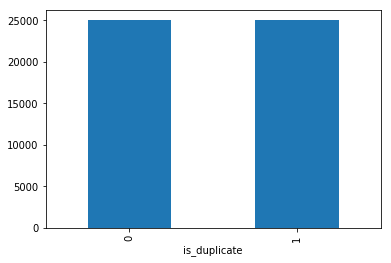

In [167]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [168]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   50000


In [169]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   50.0%

~> Question pairs are Similar (is_duplicate = 1):
   50.0%


<h3> 3.2.2 Number of unique questions </h3>

In [170]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 85408

Number of unique questions that appear more than one time: 8724 (10.214499812663918%)

Max number of times a single question is repeated: 16



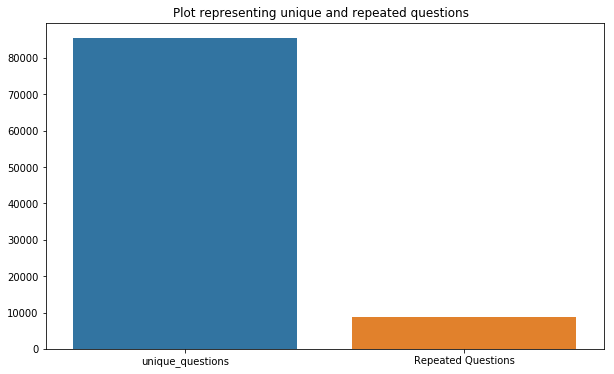

In [171]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [172]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 16



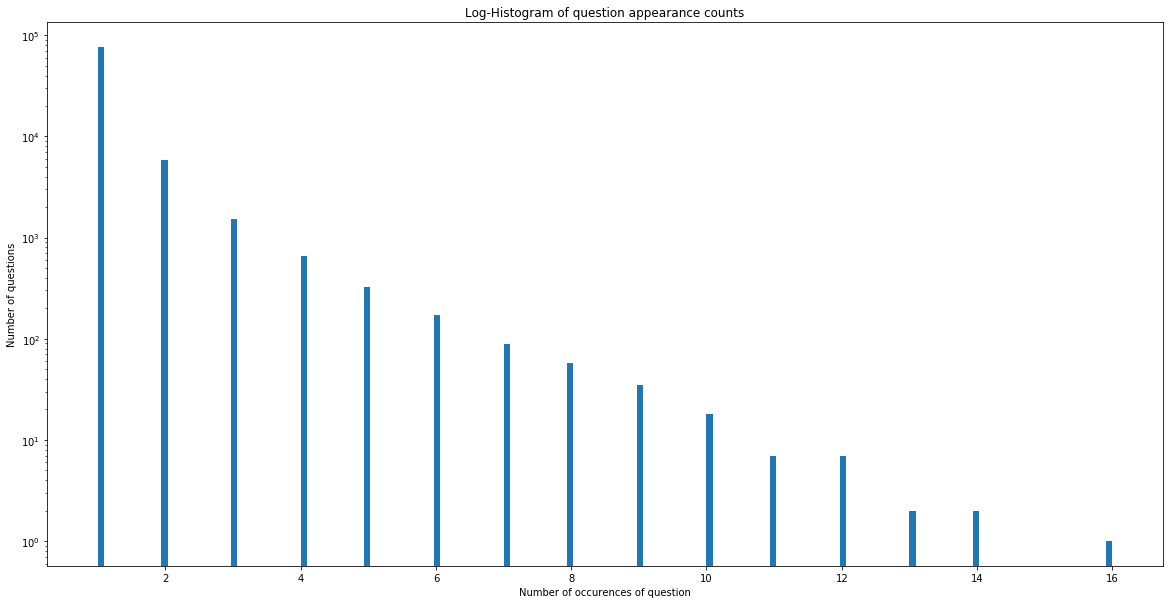

In [173]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [174]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


- There are two rows with null values in question2 

In [175]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [176]:
if os.path.isfile('./My Drive/Quora2/df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("./My Drive/Quora2/df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("./My Drive/Quora2/df_fe_without_preprocessing_train.csv", index=False)

df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0


In [177]:
df.shape

(50000, 17)

<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [178]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 9
Number of Questions with minimum length [question2] : 1


<h4> 3.3.1.1 Feature: word_share </h4>

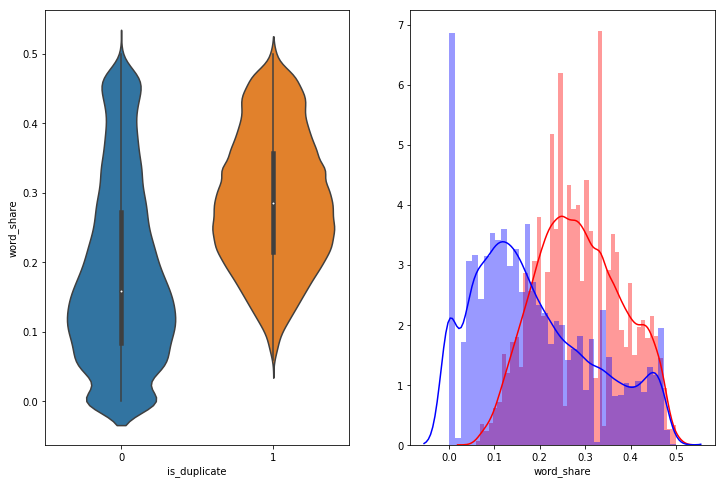

In [179]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

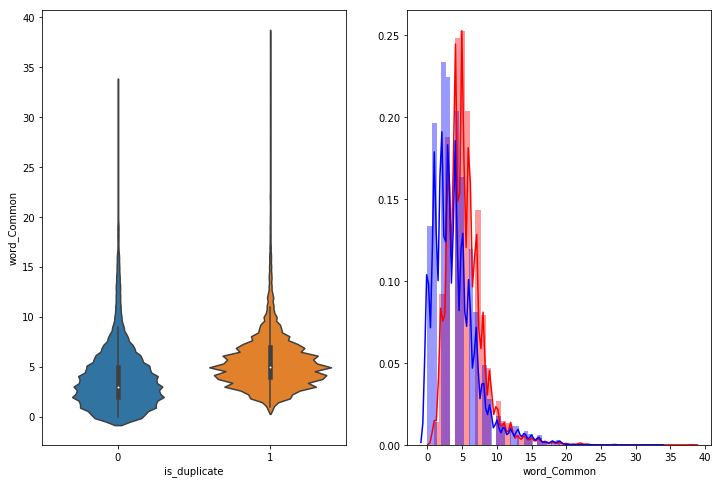

In [180]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

<h2>1.2.1 : EDA: Advanced Feature Extraction.

In [181]:
pip install fuzzywuzzy

In [182]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

<h2>3.4 Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [183]:
# To get the results in 4 decemal points
import nltk
nltk.download('stopwords')
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>3.5 Advanced Feature Extraction (NLP and Fuzzy Features)

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [0]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [185]:
if os.path.isfile('./My Drive/Quora2/nlp_features_train.csv'):
    df = pd.read_csv("./My Drive/Quora2/nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = extract_features(df)
    df.to_csv("./My Drive/Quora2/nlp_features_train.csv", index=False)
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [186]:
df.shape

(50000, 32)

<h2>3.5.1 Analysis of extracted features

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [187]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('./My Drive/Quora2/train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('./My Drive/Quora2/train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 50000
Number of data points in class 0 (non duplicate pairs) : 50000


In [188]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, './My Drive/Quora2/train_p.txt')).read()
textn_w = open(path.join(d, './My Drive/Quora2/train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 2695444
Total number of words in non duplicate pair questions : 3254369


Word Cloud for Duplicate Question pairs


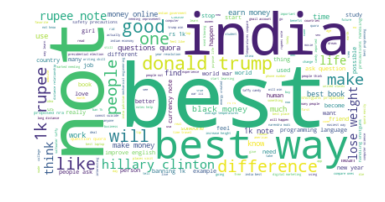

In [189]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


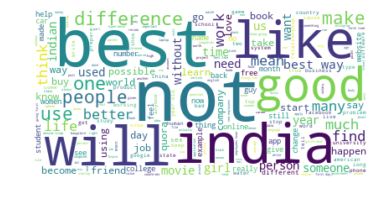

In [190]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

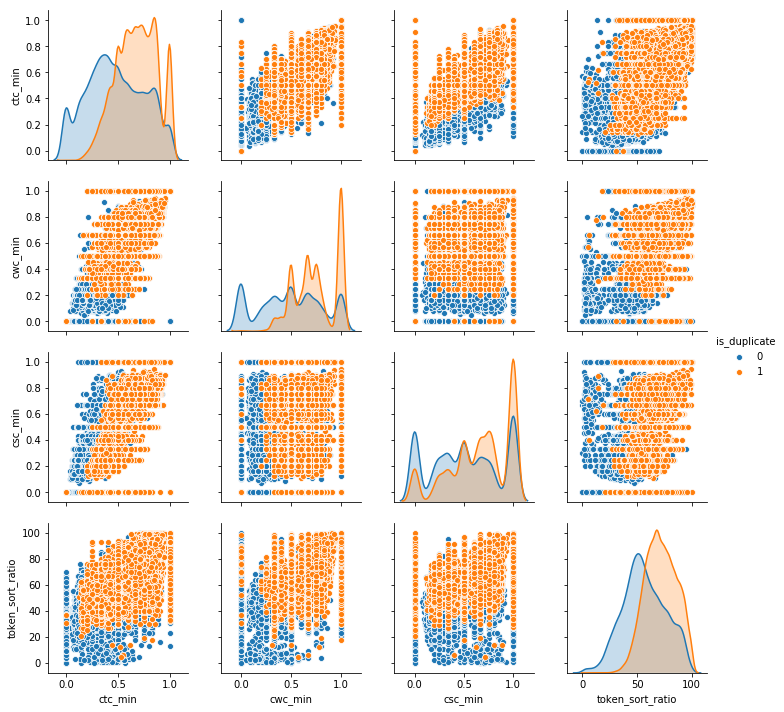

In [191]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

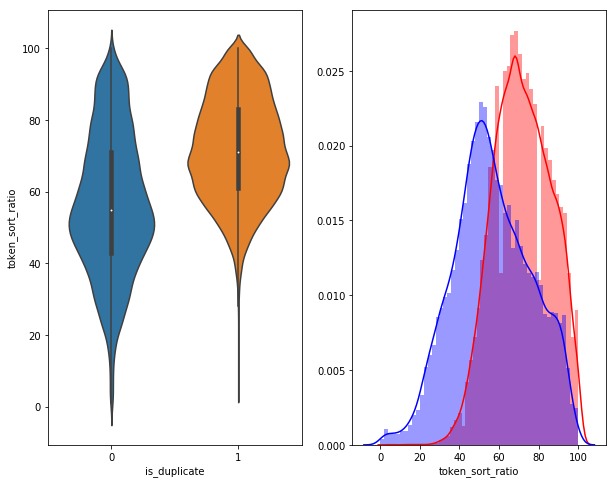

In [192]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

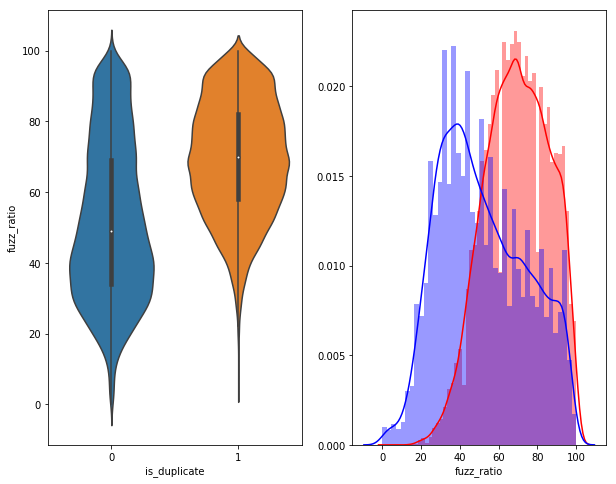

In [193]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h2>3.5.2 Visualization

In [0]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [195]:

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.021s...
[t-SNE] Computed neighbors for 5000 samples in 0.421s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.113036
[t-SNE] Computed conditional probabilities in 0.288s
[t-SNE] Iteration 50: error = 82.2266464, gradient norm = 0.0456455 (50 iterations in 3.200s)
[t-SNE] Iteration 100: error = 70.4080124, gradient norm = 0.0094598 (50 iterations in 2.027s)
[t-SNE] Iteration 150: error = 68.5708313, gradient norm = 0.0053066 (50 iterations in 1.960s)
[t-SNE] Iteration 200: error = 67.7776642, gradient norm = 0.0037753 (50 iterations in 1.936s)
[t-SNE] Iteration 250: error = 67.3147583, gradient norm = 0.0031309

In [43]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.014s...
[t-SNE] Computed neighbors for 5000 samples in 0.430s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.113036
[t-SNE] Computed conditional probabilities in 0.290s
[t-SNE] Iteration 50: error = 83.4003448, gradient norm = 0.0391808 (50 iterations in 10.936s)
[t-SNE] Iteration 100: error = 69.1974030, gradient norm = 0.0034733 (50 iterations in 5.850s)
[t-SNE] Iteration 150: error = 67.9046936, gradient norm = 0.0018418 (50 iterations in 4.943s)
[t-SNE] Iteration 200: error = 67.2827225, gradient norm = 0.0011958 (50 iterations in 5.063s)
[t-SNE] Iteration 250: error = 66.9548721, gradient norm = 0.000937

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [0]:
df.dropna(how='any', inplace = True) 

In [198]:
df.shape

(49996, 32)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [48]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 49996/49996 [07:42<00:00, 107.98it/s]


In [49]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question2'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q2_feats_m'] = list(vecs1)


100%|██████████| 49996/49996 [07:42<00:00, 108.00it/s]


In [199]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


In [200]:
columns = ['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio','longest_substr_ratio']

from sklearn.preprocessing import StandardScaler
for column in columns:
  scalar = StandardScaler()
  scalar.fit(df[column].values.reshape(-1,1))
  print(column + ": ")
  print(f"Mean : {scalar.mean_[0]}, Standard deviation : {np.sqrt(scalar.var_[0])}")
  standardized_df = scalar.transform(df[column].values.reshape(-1, 1))
  df[column] = pd.DataFrame(standardized_df)

freq_qid1: 
Mean : 1.3507880630450435, Standard deviation : 0.9993985605377591
freq_qid2: 
Mean : 1.3659492759420753, Standard deviation : 1.050095260893902
q1len: 
Mean : 58.11368909512761, Standard deviation : 28.955992674826547
q2len: 
Mean : 58.59250740059205, Standard deviation : 32.400150688640586
q1_n_words: 
Mean : 10.710156812545003, Standard deviation : 5.2350864498900895
q2_n_words: 
Mean : 10.899551964157133, Standard deviation : 6.024640628523511
word_Common: 
Mean : 4.697795823665893, Standard deviation : 3.044996174403431
word_Total: 
Mean : 20.681774541963357, Standard deviation : 8.31996865435955
word_share: 
Mean : 0.23655357186510334, Standard deviation : 0.12511841464427614
freq_q1+q2: 
Mean : 2.716737338987119, Standard deviation : 1.7427253516337018
freq_q1-q2: 
Mean : 0.41135290823265863, Standard deviation : 0.9984598517475738
cwc_min: 
Mean : 0.6202869061117658, Standard deviation : 0.29799512252192734
cwc_max: 
Mean : 0.48850342946711584, Standard deviation : 

In [201]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,-0.350999,-0.348492,0.272355,-0.049151,0.628422,0.182658,1.741284,0.278634,1.584331,-0.411274,-0.411987,1.274159,1.283122,1.229719,1.841006,1.301389,1.368468,-0.744489,0.923584,-0.323165,0.402224,1.326357,1.548243,1.508748,1.830237,2.536698
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,-0.350999,-0.348492,-0.245672,0.907634,-0.517691,0.348643,-0.229161,-0.081944,-0.292152,-0.411274,-0.411987,0.603020,-0.329352,0.478832,0.496459,0.460419,0.043729,-0.744489,0.923584,0.318680,0.302415,0.617745,-0.062127,0.249151,0.464169,0.837984


In [0]:
df_q1 = pd.DataFrame(df.q1_feats_m.values.tolist(), index= df.index)
df_q2 = pd.DataFrame(df.q2_feats_m.values.tolist(), index= df.index)

In [54]:
df_q1.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95
0,183.066797,-137.327993,-56.972606,-153.662772,-88.786487,4.487015,135.681654,46.176685,-63.537449,51.278999,65.545980,-27.959158,20.331904,-101.025230,72.308770,-78.630488,45.772627,108.143462,7.953560,104.215657,-98.416385,-94.231944,58.256423,248.630472,52.998550,89.596285,177.094751,-42.910816,41.888471,305.137298,32.106223,14.570188,-143.442012,-21.970860,21.280298,15.735318,-69.932522,78.224133,-101.352869,29.456959,...,53.873913,-4.538401,-40.868652,194.345686,-46.264366,-164.839505,176.233007,-44.582356,15.566811,61.762629,-66.611508,87.026356,-88.615013,186.132880,46.849669,-46.971335,71.713201,99.651276,133.936233,193.838731,1.556333,74.454369,-145.700658,-113.044376,-35.488733,-95.69219,-172.824495,71.757113,-4.170645,-50.882745,32.041295,-107.613003,135.660465,54.335075,-15.264864,27.417514,-78.666233,7.788994,-128.015400,67.297507
1,80.836472,-126.260577,-11.482833,-59.296239,-113.777659,-45.185599,13.408010,20.774735,-38.240806,69.168040,-66.894223,90.581762,-13.771663,-55.755772,13.724929,-35.479878,69.306645,96.205046,-23.998924,178.983838,14.104296,-135.629448,60.505978,156.571790,23.025756,40.726032,67.953202,29.952825,-26.609110,328.139437,-28.496000,-32.554210,4.463094,43.284467,97.134811,141.960679,-38.826888,23.753085,-23.885055,-5.139801,...,64.502030,48.436865,-37.269976,39.571773,-103.724460,38.821119,100.917454,69.897292,-25.639190,168.305912,23.339563,-112.639636,1.597770,-12.697529,97.695545,-14.783588,7.431633,116.867892,20.485580,9.303153,-36.616562,-32.514493,-116.090418,-61.380566,-54.113868,-36.81969,-93.970659,90.146291,-2.640457,-69.308909,85.520189,0.422361,96.031336,59.320764,22.667551,-53.861685,-163.666674,9.928385,-12.628016,62.800417


In [0]:
df_q1['id']=df['id']
df_q2['id']=df['id']
df1  = df.merge(df_q1, on='id',how='left')

In [152]:
df1.head(2)

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m,0_x,1_x,2_x,3_x,4_x,5_x,6_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,-0.350999,-0.348492,0.272355,-0.049151,0.628422,0.182658,1.741284,0.278634,1.584331,-0.411274,-0.411987,1.274159,1.283122,1.229719,1.841006,1.301389,1.368468,-0.744489,0.923584,-0.323165,0.402224,1.326357,1.548243,1.508748,1.830237,2.536698,"[183.0667974948883, -137.3279932141304, -56.97...","[147.4911630153656, -123.24782973527908, -29.6...",183.066797,-137.327993,-56.972606,-153.662772,-88.786487,4.487015,135.681654,...,66.605529,-7.276756,-26.640654,196.721040,-41.367148,-142.347762,164.505409,-48.580051,32.703476,39.646986,-72.250461,69.604115,-81.787499,164.305072,34.577985,-20.085994,65.606513,93.330473,119.739891,202.266232,-4.053720,80.106748,-130.197760,-83.991061,-32.702219,-80.221560,-160.613253,53.661328,-9.342960,-62.817680,34.236569,-101.344411,129.315730,42.365649,-5.507099,8.221156,-58.613495,-9.395279,-105.285992,62.558955
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,-0.350999,-0.348492,-0.245672,0.907634,-0.517691,0.348643,-0.229161,-0.081944,-0.292152,-0.411274,-0.411987,0.603020,-0.329352,0.478832,0.496459,0.460419,0.043729,-0.744489,0.923584,0.318680,0.302415,0.617745,-0.062127,0.249151,0.464169,0.837984,"[80.83647203445435, -126.2605767250061, -11.48...","[132.76509702205658, -56.40194761753082, -27.0...",80.836472,-126.260577,-11.482833,-59.296239,-113.777659,-45.185599,13.408010,...,107.586672,-29.238126,-98.425968,102.547407,-176.677413,119.879132,172.757361,96.086078,-30.421774,109.238699,2.995172,-46.965768,-20.472636,36.700817,100.351525,-149.135307,-65.532330,202.408242,86.987637,-15.286116,-95.454268,-69.497493,-135.044784,-95.905366,-8.699444,-145.033698,-161.279339,123.330697,-68.309959,-66.905684,131.455782,-25.774683,107.433001,127.675180,10.519739,-27.671374,-64.919556,3.840475,-18.412700,93.238977


In [0]:
df1  = df1.merge(df_q2, on='id',how='left')

In [108]:
df1.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m,0_x,1_x,2_x,3_x,4_x,5_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,-0.350999,-0.348492,0.272355,-0.049151,0.628422,0.182658,1.741284,0.278634,1.584331,-0.411274,-0.411987,1.274159,1.283122,1.229719,1.841006,1.301389,1.368468,-0.744489,0.923584,-0.323165,0.402224,1.326357,1.548243,1.508748,1.830237,2.536698,"[183.0667974948883, -137.3279932141304, -56.97...","[147.4911630153656, -123.24782973527908, -29.6...",183.066797,-137.327993,-56.972606,-153.662772,-88.786487,4.487015,...,66.605529,-7.276756,-26.640654,196.721040,-41.367148,-142.347762,164.505409,-48.580051,32.703476,39.646986,-72.250461,69.604115,-81.787499,164.305072,34.577985,-20.085994,65.606513,93.330473,119.739891,202.266232,-4.053720,80.106748,-130.197760,-83.991061,-32.702219,-80.221560,-160.613253,53.661328,-9.342960,-62.817680,34.236569,-101.344411,129.315730,42.365649,-5.507099,8.221156,-58.613495,-9.395279,-105.285992,62.558955
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,-0.350999,-0.348492,-0.245672,0.907634,-0.517691,0.348643,-0.229161,-0.081944,-0.292152,-0.411274,-0.411987,0.603020,-0.329352,0.478832,0.496459,0.460419,0.043729,-0.744489,0.923584,0.318680,0.302415,0.617745,-0.062127,0.249151,0.464169,0.837984,"[80.83647203445435, -126.2605767250061, -11.48...","[132.76509702205658, -56.40194761753082, -27.0...",80.836472,-126.260577,-11.482833,-59.296239,-113.777659,-45.185599,...,107.586672,-29.238126,-98.425968,102.547407,-176.677413,119.879132,172.757361,96.086078,-30.421774,109.238699,2.995172,-46.965768,-20.472636,36.700817,100.351525,-149.135307,-65.532330,202.408242,86.987637,-15.286116,-95.454268,-69.497493,-135.044784,-95.905366,-8.699444,-145.033698,-161.279339,123.330697,-68.309959,-66.905684,131.455782,-25.774683,107.433001,127.675180,10.519739,-27.671374,-64.919556,3.840475,-18.412700,93.238977


In [109]:
df1.shape

(49996, 226)

<h2>4.3 Random train test split( 70:30)

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [0]:
df1.dropna(how='any', inplace = True) 

In [0]:
y = df1["is_duplicate"]
df1.drop(["is_duplicate"], axis = 1, inplace = True)

In [111]:
df1.shape

(49992, 226)

In [0]:
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(df, y, stratify=y, test_size=0.3)

In [114]:
X_train.shape

(34994, 225)

In [115]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.5 Class 1:  0.5
---------- Distribution of output variable in train data ----------
Class 0:  0.5 Class 1:  0.5


In [0]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.show()

<h2> TFIDF Features

In [205]:
from sklearn.feature_extraction.text import TfidfVectorizer
print("_"*25+"Question1 TFIDF"+"_"*25)
vectorizer8 = TfidfVectorizer(min_df=10)
vectorizer8.fit(X_train['question1'])
q1_tfidf_train = vectorizer8.transform(X_train['question1'])
q1_tfidf_test = vectorizer8.transform(X_test['question1'])
print("Shape of train matrix after one hot encodig ",q1_tfidf_train.shape)
print("Shape of test matrix after one hot encodig ",q1_tfidf_test.shape)
print("="*100)


print("_"*25+"Question2 TFIDF"+"_"*25)
vectorizer9 = TfidfVectorizer(min_df=10)
vectorizer9.fit_transform(X_train['question2'])
q2_tfidf_train = vectorizer9.transform(X_train['question2'])
q2_tfidf_test = vectorizer9.transform(X_test['question2'])
print("Shape of train matrix after one hot encodig ",q2_tfidf_train.shape)
print("Shape of test matrix after one hot encodig ",q2_tfidf_test.shape)

_________________________Question1 TFIDF_________________________
Shape of train matrix after one hot encodig  (34994, 3092)
Shape of test matrix after one hot encodig  (14998, 3092)
_________________________Question2 TFIDF_________________________
Shape of train matrix after one hot encodig  (34994, 3140)
Shape of test matrix after one hot encodig  (14998, 3140)


In [0]:
X_train.drop(['qid1', 'qid2', 'question1', 'question2','id', 'q1_feats_m','q2_feats_m'], axis=1, inplace=True)
X_test.drop(['qid1', 'qid2', 'question1', 'question2','id', 'q1_feats_m','q2_feats_m'], axis=1, inplace=True)

In [117]:
X_train.head(2)

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,...,56_y,57_y,58_y,59_y,60_y,61_y,62_y,63_y,64_y,65_y,66_y,67_y,68_y,69_y,70_y,71_y,72_y,73_y,74_y,75_y,76_y,77_y,78_y,79_y,80_y,81_y,82_y,83_y,84_y,85_y,86_y,87_y,88_y,89_y,90_y,91_y,92_y,93_y,94_y,95_y
15464,-0.350999,-0.348492,-0.591024,1.771828,-0.899729,1.012583,-0.885977,0.158441,-1.164053,-0.411274,-0.411987,-1.242615,-1.445695,-0.272067,-0.960119,-0.96276,-1.405461,-0.744489,-1.082738,1.602369,0.102799,-1.305630,-1.296743,-1.150402,-0.191544,-0.630683,79.242763,-76.427641,21.792422,-12.162138,-85.634165,23.219285,89.447552,-35.990999,-5.104716,61.559670,15.826856,-19.934621,-28.306557,-84.256817,...,116.072419,-0.222476,-92.232506,60.405421,-13.816824,-6.752251,37.063958,-36.735651,32.587145,84.772366,-8.351627,16.527164,-30.282394,-19.057731,-19.418930,-25.833769,39.102988,44.935713,20.632483,55.344034,-18.611908,8.660147,-27.245067,-5.194113,-5.573450,-2.032806,-32.563085,72.008889,54.128444,-16.442866,24.764229,7.131057,44.755946,-4.653911,-9.296753,30.032188,-16.366567,-58.273801,-19.250827,-9.358511
30161,-0.350999,-0.348492,-0.245672,-0.080015,-0.326672,-0.149312,0.756061,-0.202137,1.053941,-0.411274,-0.411987,0.435223,0.042750,1.229694,1.168727,0.76230,1.012560,1.343203,0.923584,-0.537113,-0.296434,0.870821,0.957774,0.902275,0.464169,-0.344997,66.926793,15.769421,17.359013,-25.281916,0.616048,9.222272,7.666660,4.717764,-42.027396,66.373581,47.148622,-6.947918,-14.020456,-58.020052,...,-3.052337,23.096180,31.623722,23.855595,1.847488,1.259955,49.139502,0.306515,4.775153,86.950550,31.161892,8.687637,-15.641107,-20.045328,-50.116916,-22.930954,-58.277240,24.016797,-6.811464,-43.136560,47.516393,-86.725685,-40.920244,-9.695602,-5.651046,-8.974413,20.714027,56.390695,12.735601,-0.556726,6.924740,4.155192,30.096087,42.322983,-22.951905,-17.540679,48.587428,47.198676,-16.619840,10.971539


In [118]:
X_train.shape

(34994, 218)

In [119]:
X_test.shape

(14998, 218)

In [0]:
from sklearn import preprocessing 

for f in X_train.columns: 
    if X_train[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X_train[f].values)) 
        X_train[f] = lbl.transform(list(X_train[f].values))

for f in X_test.columns: 
    if X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X_test[f].values)) 
        X_test[f] = lbl.transform(list(X_test[f].values))

X_train.fillna((-999), inplace=True) 
X_test.fillna((-999), inplace=True)

train1=np.array(X_train) 
test1=np.array(X_test) 
X_train = train1.astype(float) 
X_test = test1.astype(float)

<h2>Logistic Regression with hyperparameter tuning (TFIDF weighted W2V)

For values of alpha =  1e-05 The log loss is: 0.6931471805599453
For values of alpha =  0.0001 The log loss is: 0.5091347858590833
For values of alpha =  0.001 The log loss is: 0.5199967097951628
For values of alpha =  0.01 The log loss is: 0.5338503762012379
For values of alpha =  0.1 The log loss is: 0.5112823402578778
For values of alpha =  1 The log loss is: 0.5151353602757957
For values of alpha =  10 The log loss is: 0.5990821400526668


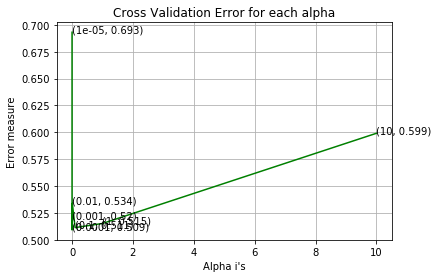

For values of best alpha =  0.0001 The train log loss is: 0.5076124311962193
For values of best alpha =  0.0001 The test log loss is: 0.5091347858590833
Total number of data points : 14998


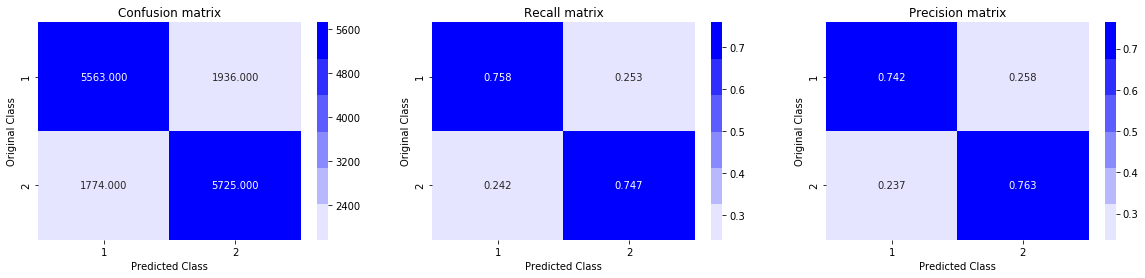

In [121]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, class_weight = 'balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, class_weight = 'balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<b> Here the Recall(TPR) = 0.747 i.e., out of total positive  points 74.7% are correctly predicted.</b>

<b>
               Recall = TP/(TP + FN)
  
<b> Precision = 0.763  i.e., out of total points for which the model predicted as positive class 76.3% are true.
  
  <b>         Precision = TP/(TP + FP)
    
 <b>   TNR = 0.758  which seems the model is performing well for the negative points.
  

<h2><h2>Linear SVM with hyperparameter tuning (TFIDF weighted W2V)

For values of alpha =  1e-05 The log loss is: 0.6931471805599453
For values of alpha =  0.0001 The log loss is: 0.6931471805599453
For values of alpha =  0.001 The log loss is: 0.46991012224646067
For values of alpha =  0.01 The log loss is: 0.49142282949650967
For values of alpha =  0.1 The log loss is: 0.5682638211856019
For values of alpha =  1 The log loss is: 0.6835963352304967
For values of alpha =  10 The log loss is: 0.6931471805599453


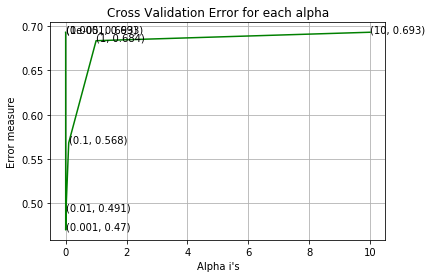

For values of best alpha =  0.001 The train log loss is: 0.4698501197334016
For values of best alpha =  0.001 The test log loss is: 0.46991012224646067
Total number of data points : 14998


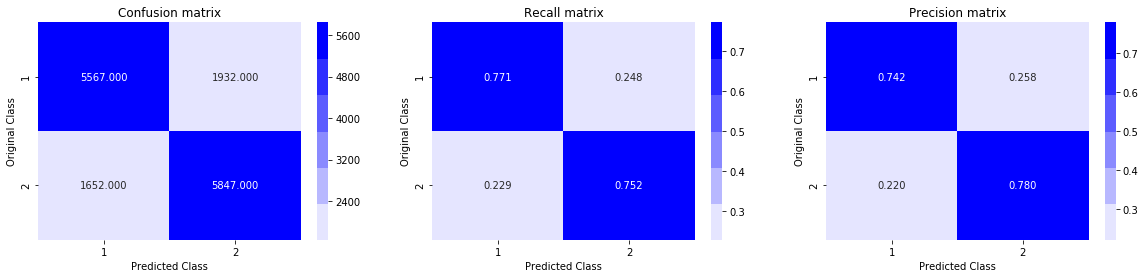

In [122]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, class_weight = 'balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42, class_weight = 'balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<b> Here the Recall(TPR) = 0.752 i.e., out of total positive  points 75.2% are correctly predicted.</b>

<b>
               Recall = TP/(TP + FN)
  
<b> Precision = 0.780  i.e., out of total points for which the model predicted as positive class 78% are true.
  
  <b>         Precision = TP/(TP + FP)
    
 <b>   TNR = 0.771  which seems the model is performing well for the negative points.
  

<h2>4.6 XGBoost with parameter tuning (RandomSearch)

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold

n_estimators = [100, 300, 500, 700, 900, 1100, 1300, 1500]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
colsample_bytree = [0.1, 0.3, 0.5, 0.7 , 0.9, 1]
subsample = [0.1,0.3,0.5,0.7,0.9,1]

def hyperparameter_tunning(X,Y):
    param_grid = dict(learning_rate=learning_rate,
                      n_estimators=n_estimators,
                      colsample_bytree = colsample_bytree,
                      subsample = subsample)
    
    model = XGBClassifier(nthread=-1)
    kfold = StratifiedKFold(n_splits=5, shuffle=True)
    random_search = RandomizedSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
    random_result = random_search.fit(X,Y)
    
    # Summarize results
    print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
    print()
    means = random_result.cv_results_['mean_test_score']
    stds = random_result.cv_results_['std_test_score']
    params = random_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
        
    return random_result

In [124]:
start = dt.datetime.now()

# Tune hyperparameter values
random_result = hyperparameter_tunning(X_train,y_train)

print("\nTimeTaken: ",dt.datetime.now() - start)

Best: -0.345903 using {'subsample': 0.5, 'n_estimators': 1100, 'learning_rate': 0.1, 'colsample_bytree': 1}

-0.365879 (0.004230) with: {'subsample': 0.3, 'n_estimators': 1500, 'learning_rate': 0.1, 'colsample_bytree': 0.1}
-0.356139 (0.003697) with: {'subsample': 0.7, 'n_estimators': 700, 'learning_rate': 0.2, 'colsample_bytree': 0.3}
-0.359284 (0.003443) with: {'subsample': 0.5, 'n_estimators': 300, 'learning_rate': 0.2, 'colsample_bytree': 0.3}
-0.357010 (0.005302) with: {'subsample': 0.9, 'n_estimators': 900, 'learning_rate': 0.2, 'colsample_bytree': 0.1}
-0.689719 (0.000032) with: {'subsample': 0.9, 'n_estimators': 100, 'learning_rate': 0.0001, 'colsample_bytree': 0.9}
-0.689803 (0.000031) with: {'subsample': 0.5, 'n_estimators': 100, 'learning_rate': 0.0001, 'colsample_bytree': 0.7}
-0.345903 (0.003506) with: {'subsample': 0.5, 'n_estimators': 1100, 'learning_rate': 0.1, 'colsample_bytree': 1}
-0.689690 (0.000033) with: {'subsample': 0.7, 'n_estimators': 100, 'learning_rate': 0.0

In [125]:
import xgboost as xgb

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 3
params['colsample_bytree'] = 0.7
params['n_estimators'] = 500
params['subsample'] = 1
params['learning_rate'] = 0.3
params['nthread'] = -1
params['silent'] = 1

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist,verbose_eval= False,early_stopping_rounds=20)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
print("\nTime Taken: ",dt.datetime.now() - start)

The test log loss is: 0.3415650370617024

Time Taken:  0:35:05.913193


Total number of data points : 14998


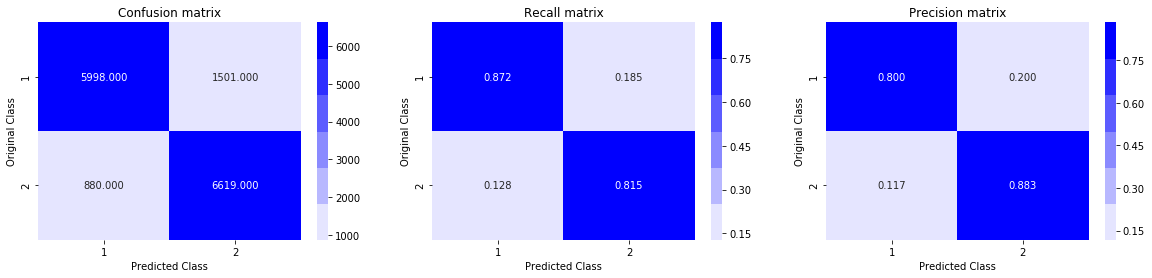

In [126]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<b>The Hyperparameter tuning is done for the XGBOOST classifier where colsample_bytree, n_estimators, learning_rate, subsample are considered as 4 hyperparameters.</b>

<b> Here the Recall(TPR) = 0.815 i.e., out of total positive  points 81.5% are correctly predicted.</b>

<b>
               Recall = TP/(TP + FN)
  
<b> Precision = 0.883  i.e., out of total points for which the model predicted as positive class 88.3% are true.
  
  <b>         Precision = TP/(TP + FP)
  



<h2>Logistic Regression with hyperparameter tuning (TFIDF)

In [207]:
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X_train = hstack((X_train,q1_tfidf_train,q2_tfidf_train))
X_test = hstack((X_test,q1_tfidf_test,q2_tfidf_test))
X_train = X_train.tocsr()
X_test = X_test.tocsr()
print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)

(34994, 6258) (34994,)
(14998, 6258) (14998,)


For values of alpha =  1e-05 The log loss is: 0.4100676187806122
For values of alpha =  0.0001 The log loss is: 0.399551468766388
For values of alpha =  0.001 The log loss is: 0.42563266600133476
For values of alpha =  0.01 The log loss is: 0.45792038066088564
For values of alpha =  0.1 The log loss is: 0.48733261803603195
For values of alpha =  1 The log loss is: 0.527933760890449
For values of alpha =  10 The log loss is: 0.5528078170011824


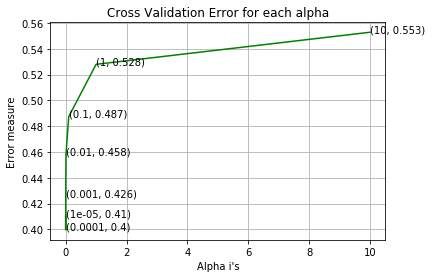

For values of best alpha =  0.0001 The train log loss is: 0.3653458108955217
For values of best alpha =  0.0001 The test log loss is: 0.399551468766388
Total number of data points : 14998


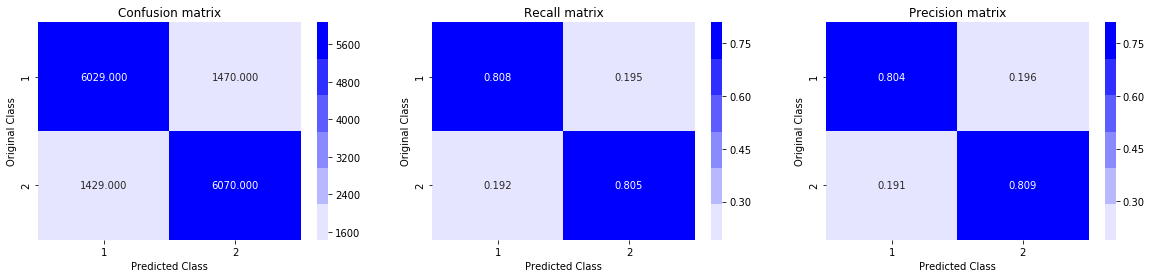

In [208]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42, class_weight = 'balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42, class_weight = 'balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<b> Here the Recall(TPR) = 0.805 i.e., out of total positive  points 80.5% are correctly predicted.</b>

<b>
               Recall = TP/(TP + FN)
  
<b> Precision = 0.809  i.e., out of total points for which the model predicted as positive class 80.9% are true.
  
  <b>         Precision = TP/(TP + FP)
    
 <b>   TNR = 0.808  which seems the model is performing well for the negative points.
  

<h2>Linear SVM with hyperparameter tuning (TFIDF)

For values of alpha =  1e-05 The log loss is: 0.45014217369546017
For values of alpha =  0.0001 The log loss is: 0.4074772303507898
For values of alpha =  0.001 The log loss is: 0.45088697522211557
For values of alpha =  0.01 The log loss is: 0.4714200638007782
For values of alpha =  0.1 The log loss is: 0.5110453797952003
For values of alpha =  1 The log loss is: 0.6931471805599453
For values of alpha =  10 The log loss is: 0.6931471805599453


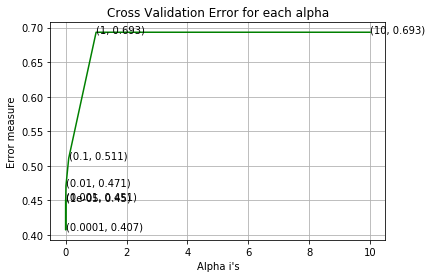

For values of best alpha =  0.0001 The train log loss is: 0.3865680963204368
For values of best alpha =  0.0001 The test log loss is: 0.4074772303507898
Total number of data points : 14998


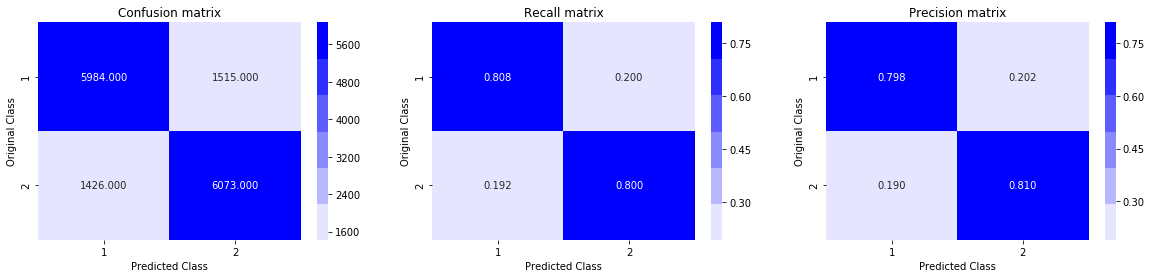

In [209]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, class_weight = 'balanced')
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42, class_weight = 'balanced')
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<b> Here the Recall(TPR) = 0.800 i.e., out of total positive  points 80.0% are correctly predicted.</b>

<b>
               Recall = TP/(TP + FN)
  
<b> Precision = 0.810  i.e., out of total points for which the model predicted as positive class 81.0% are true.
  
  <b>         Precision = TP/(TP + FP)
     
   TNR = 0.808  which seems the model is performing well for the negative points
  